Samara Holmes

Detecting glass walls using only monocular information

Glass Window/Wall Detection Pipeline

This notebook implements a complete pipeline for detecting glass surfaces in images:

1. Semantic/Binary segmentation to identify glass regions
2. Bounding box extraction around detected glass areas
3. Depth map generation to analyze spatial relationships

## Setup

In [21]:
import torch
import torchvision
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import warnings
warnings.filterwarnings('ignore')
from scipy import ndimage
from skimage import morphology
from sklearn.cluster import DBSCAN

# For segmentation
from transformers import AutoImageProcessor, AutoModelForSemanticSegmentation

# For depth estimation
from transformers import DPTImageProcessor, DPTForDepthEstimation

import requests
from io import BytesIO

## Load models

1. Semantic Segmentation
- Uses SegFormer model fine-tuned on ADE20K dataset
- Identifies glass regions at the pixel level
- Creates binary masks for glass surfaces

2. Bounding Box Detection
- Extracts contours from the binary glass mask
- Filters out noise using area thresholds
- Draws bounding boxes around detected glass regions

3. Depth Estimation
- Uses Intel's DPT (Dense Prediction Transformer) model
- Generates depth maps to understand spatial relationships
- Analyzes depth statistics specifically for glass regions

In [22]:
class GlassAwareDepthPipeline:
    def __init__(self, device='cuda' if torch.cuda.is_available() else 'cpu'):
        self.device = device
        print(f"Using device: {device}")
        
        # Initialize segmentation model
        print("Loading segmentation model...")
        self.seg_processor = AutoImageProcessor.from_pretrained("nvidia/segformer-b5-finetuned-ade-640-640")
        self.seg_model = AutoModelForSemanticSegmentation.from_pretrained(
            "nvidia/segformer-b5-finetuned-ade-640-640"
        ).to(device)
        
        # Initialize depth estimation model
        print("Loading depth estimation model...")
        self.depth_processor = DPTImageProcessor.from_pretrained("Intel/dpt-large")
        self.depth_model = DPTForDepthEstimation.from_pretrained("Intel/dpt-large").to(device)
        
        print("Models loaded successfully!")
    
    def load_image(self, image_path):
        """Load image from file path or URL"""
        if image_path.startswith('http'):
            response = requests.get(image_path)
            img = Image.open(BytesIO(response.content)).convert('RGB')
        else:
            img = Image.open(image_path).convert('RGB')
        
        img_array = np.array(img)
        return img, img_array
    
    def segment_image(self, image):
        """Perform semantic segmentation"""
        inputs = self.seg_processor(images=image, return_tensors="pt")
        inputs = {k: v.to(self.device) for k, v in inputs.items()}
        
        with torch.no_grad():
            outputs = self.seg_model(**inputs)
        
        logits = outputs.logits
        upsampled_logits = torch.nn.functional.interpolate(
            logits,
            size=image.size[::-1],
            mode="bilinear",
            align_corners=False,
        )
        
        seg_map = upsampled_logits.argmax(dim=1)[0].cpu().numpy()
        return seg_map
    
    def estimate_depth(self, image):
        """Estimate depth map"""
        inputs = self.depth_processor(images=image, return_tensors="pt")
        inputs = {k: v.to(self.device) for k, v in inputs.items()}
        
        with torch.no_grad():
            outputs = self.depth_model(**inputs)
        
        predicted_depth = outputs.predicted_depth
        
        prediction = torch.nn.functional.interpolate(
            predicted_depth.unsqueeze(1),
            size=image.size[::-1],
            mode="bicubic",
            align_corners=False,
        )
        
        depth_map = prediction.squeeze().cpu().numpy()
        return depth_map
    
    def detect_glass_by_depth_anomaly(self, depth_map, seg_map):
        """
        Detect glass by identifying depth anomalies:
        - Depth discontinuities at boundaries
        - Areas where depth is inconsistent with surrounding structure
        - Regions that should be at similar depth but show variation
        """
        
        # Normalize depth map
        depth_norm = (depth_map - depth_map.min()) / (depth_map.max() - depth_map.min())
        
        # 1. Detect depth discontinuities using gradient
        grad_x = np.abs(np.gradient(depth_norm, axis=1))
        grad_y = np.abs(np.gradient(depth_norm, axis=0))
        depth_edges = np.sqrt(grad_x**2 + grad_y**2)
        
        # 2. Find regions with high depth variance (glass often causes this)
        kernel_size = 15
        kernel = np.ones((kernel_size, kernel_size)) / (kernel_size**2)
        depth_mean = cv2.filter2D(depth_norm, -1, kernel)
        depth_variance = cv2.filter2D((depth_norm - depth_mean)**2, -1, kernel)
        
        # 3. Detect "see-through" regions - areas where depth is deeper than expected
        # based on surrounding structure
        depth_median = cv2.medianBlur((depth_norm * 255).astype(np.uint8), 21) / 255.0
        depth_difference = depth_norm - depth_median
        see_through_mask = depth_difference > 0.1  # Regions deeper than local median
        
        # 4. Combine indicators
        # High edge + high variance + see-through = likely glass
        glass_score = (depth_edges > 0.1).astype(float) * 0.3 + \
                     (depth_variance > 0.01).astype(float) * 0.3 + \
                     see_through_mask.astype(float) * 0.4
        
        # Threshold to get binary mask
        glass_anomaly_mask = glass_score > 0.5
        
        # Clean up the mask
        glass_anomaly_mask = morphology.opening(glass_anomaly_mask, morphology.disk(3))
        glass_anomaly_mask = morphology.closing(glass_anomaly_mask, morphology.disk(5))
        
        return glass_anomaly_mask, depth_edges, see_through_mask, depth_variance
    
    def extract_glass_mask_combined(self, seg_map, depth_anomaly_mask):
        """
        Combine segmentation and depth anomaly detection for better glass detection
        """
        # Glass-related classes in ADE20K
        glass_classes = [6, 8, 64]  # window, windowpane, glass
        
        # Segmentation-based mask
        seg_glass_mask = np.zeros_like(seg_map, dtype=bool)
        for class_id in glass_classes:
            seg_glass_mask |= (seg_map == class_id)
        
        # Combine with depth anomaly
        # Trust depth anomaly more for detecting transparent surfaces
        combined_mask = seg_glass_mask | depth_anomaly_mask
        
        # Convert to uint8
        combined_mask = (combined_mask * 255).astype(np.uint8)
        
        # Morphological operations to clean up
        kernel = np.ones((5, 5), np.uint8)
        combined_mask = cv2.morphologyEx(combined_mask, cv2.MORPH_CLOSE, kernel)
        combined_mask = cv2.morphologyEx(combined_mask, cv2.MORPH_OPEN, kernel)
        
        return combined_mask
    
    def analyze_depth_correction_quality(self, original_depth, corrected_depth, glass_mask):
        """
        Analyze how well the depth correction worked
        """
        if not np.any(glass_mask > 0):
            return None
        
        # Get surrounding non-glass depth for comparison
        kernel = np.ones((25, 25), np.uint8)
        dilated = cv2.dilate((glass_mask > 0).astype(np.uint8), kernel, iterations=1)
        surrounding_mask = (dilated > 0) & (glass_mask == 0)
        
        if np.any(surrounding_mask):
            surrounding_depth = np.median(original_depth[surrounding_mask])
            
            # Compare glass depths before and after correction
            glass_depth_before = original_depth[glass_mask > 0]
            glass_depth_after = corrected_depth[glass_mask > 0]
            
            analysis = {
                'surrounding_depth': surrounding_depth,
                'glass_depth_before_mean': np.mean(glass_depth_before),
                'glass_depth_after_mean': np.mean(glass_depth_after),
                'depth_error_before': np.abs(np.mean(glass_depth_before) - surrounding_depth),
                'depth_error_after': np.abs(np.mean(glass_depth_after) - surrounding_depth),
                'improvement_percentage': 0,
                'depth_consistency_score': np.std(glass_depth_after) / (np.std(glass_depth_before) + 1e-6)
            }
            
            # Calculate improvement
            if analysis['depth_error_before'] > 0:
                improvement = (analysis['depth_error_before'] - analysis['depth_error_after']) / analysis['depth_error_before']
                analysis['improvement_percentage'] = improvement * 100
            
            return analysis
        
        return None
    
    def find_and_classify_bboxes(self, glass_mask, depth_map):
        """
        Find bounding boxes and classify them based on depth characteristics
        """
        contours, _ = cv2.findContours(glass_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        classified_bboxes = []
        for contour in contours:
            area = cv2.contourArea(contour)
            if area < 500:
                continue
            
            x, y, w, h = cv2.boundingRect(contour)
            
            # Analyze depth in this bbox
            bbox_depth = depth_map[y:y+h, x:x+w]
            depth_variance = np.var(bbox_depth)
            mean_depth = np.mean(bbox_depth)
            
            # Classify based on depth characteristics
            if depth_variance > 0.1:
                glass_type = "Transparent/Reflective"
                confidence = min(depth_variance * 5, 1.0)
            else:
                glass_type = "Opaque/Frosted"
                confidence = 1.0 - min(depth_variance * 10, 0.5)
            
            classified_bboxes.append({
                'bbox': (x, y, w, h),
                'area': area,
                'glass_type': glass_type,
                'confidence': confidence,
                'mean_depth': mean_depth,
                'depth_variance': depth_variance
            })
        
        classified_bboxes.sort(key=lambda x: x['area'], reverse=True)
        return classified_bboxes
    
    def correct_depth_for_glass(self, depth_map, glass_mask):
        """
        Correct depth map for glass regions by matching surrounding non-glass depth
        """
        corrected_depth = depth_map.copy()
        
        # Label connected components (individual glass regions)
        labeled_mask, num_features = ndimage.label(glass_mask > 0)
        
        for i in range(1, num_features + 1):
            region_mask = labeled_mask == i
            
            # Method 1: Use depth from immediate surrounding non-glass pixels
            surrounding_depth = self.get_surrounding_depth(region_mask, depth_map, glass_mask)
            
            if surrounding_depth is not None:
                # Fill glass region with surrounding depth
                corrected_depth[region_mask] = surrounding_depth
            else:
                # Method 2: Use morphological operations to "inpaint" from edges
                corrected_depth = self.inpaint_depth_region(corrected_depth, region_mask)
        
        # Smooth the transition between corrected and original regions
        corrected_depth = self.smooth_depth_transitions(corrected_depth, glass_mask, depth_map)
        
        return corrected_depth
    
    def get_surrounding_depth(self, region_mask, depth_map, glass_mask):
        """
        Get average depth of non-glass pixels immediately surrounding a glass region
        """
        # Dilate the region to get surrounding area
        kernel = np.ones((15, 15), np.uint8)  # Adjust size based on typical window frame width
        dilated = cv2.dilate(region_mask.astype(np.uint8), kernel, iterations=1)
        
        # Get surrounding pixels (dilated - original, excluding other glass)
        surrounding_mask = (dilated > 0) & (~region_mask) & (glass_mask == 0)
        
        if np.any(surrounding_mask):
            # Get depth values of surrounding non-glass pixels
            surrounding_depths = depth_map[surrounding_mask]
            
            # Use robust statistics to avoid outliers
            # Use median or trimmed mean to handle variations
            surrounding_depth = np.median(surrounding_depths)
            
            # Alternative: use mode of quantized depths for most common surrounding depth
            quantized = np.round(surrounding_depths, 2)
            unique, counts = np.unique(quantized, return_counts=True)
            if len(unique) > 0:
                mode_depth = unique[np.argmax(counts)]
                # Use mode if it's common enough, otherwise use median
                if counts[np.argmax(counts)] > len(surrounding_depths) * 0.2:
                    surrounding_depth = mode_depth
            
            return surrounding_depth
        
        return None
    
    def inpaint_depth_region(self, depth_map, region_mask):
        """
        Inpaint glass region using surrounding depth values
        """
        # Convert to format suitable for inpainting
        depth_normalized = ((depth_map - depth_map.min()) / 
                          (depth_map.max() - depth_map.min()) * 255).astype(np.uint8)
        
        # Create inpainting mask
        inpaint_mask = (region_mask * 255).astype(np.uint8)
        
        # Inpaint using OpenCV
        inpainted = cv2.inpaint(depth_normalized, inpaint_mask, 3, cv2.INPAINT_TELEA)
        
        # Convert back to original depth scale
        inpainted_depth = (inpainted.astype(float) / 255) * (depth_map.max() - depth_map.min()) + depth_map.min()
        
        # Only update the glass region
        result = depth_map.copy()
        result[region_mask] = inpainted_depth[region_mask]
        
        return result
    
    def smooth_depth_transitions(self, corrected_depth, glass_mask, original_depth):
        """
        Smooth the transitions between corrected glass regions and original depth
        """
        # Create a weight mask for blending
        # Distance transform from glass edges
        dist_transform = cv2.distanceTransform((glass_mask > 0).astype(np.uint8), 
                                              cv2.DIST_L2, 5)
        
        # Normalize distance transform to create blend weights
        if dist_transform.max() > 0:
            blend_weight = np.clip(dist_transform / 10.0, 0, 1)  # Adjust divisor for blend width
            
            # Blend corrected and original based on distance from edge
            smoothed = corrected_depth * blend_weight + original_depth * (1 - blend_weight)
            
            # Only apply smoothing to glass regions
            result = original_depth.copy()
            result[glass_mask > 0] = smoothed[glass_mask > 0]
            
            return result
        
        return corrected_depth
    
    def visualize_glass_depth_analysis(self, image, depth_map, glass_mask, 
                                       corrected_depth, bboxes, seg_map):
        """
        Comprehensive visualization of glass detection and depth analysis
        """
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        
        # Original image
        axes[0, 0].imshow(image)
        axes[0, 0].set_title('Original Image')
        axes[0, 0].axis('off')
        
        # Segmentation map
        axes[0, 1].imshow(seg_map, cmap='tab20')
        axes[0, 1].set_title('Semantic Segmentation')
        axes[0, 1].axis('off')
        
        # Glass mask
        axes[0, 2].imshow(glass_mask, cmap='gray')
        axes[0, 2].set_title('Detected Glass Regions')
        axes[0, 2].axis('off')
        
        # Bounding boxes with classification
        img_with_boxes = np.array(image).copy()
        for i, bbox_info in enumerate(bboxes[:5]):
            x, y, w, h = bbox_info['bbox']
            color = (0, 255, 0) if bbox_info['glass_type'] == "Transparent/Reflective" else (255, 255, 0)
            cv2.rectangle(img_with_boxes, (x, y), (x+w, y+h), color, 3)
            label = f"Glass {i+1}"
            cv2.putText(img_with_boxes, label, (x, y-10), 
                       cv2.FONT_HERSHEY_SIMPLEX, 0.9, color, 2)
        
        axes[1, 0].imshow(img_with_boxes)
        axes[1, 0].set_title('Glass Bounding Boxes')
        axes[1, 0].axis('off')
        
        # Original vs Corrected depth comparison
        vmin = min(depth_map.min(), corrected_depth.min())
        vmax = max(depth_map.max(), corrected_depth.max())
        
        im1 = axes[1, 1].imshow(depth_map, cmap='plasma', vmin=vmin, vmax=vmax)
        axes[1, 1].set_title('Original Depth (No Correction)')
        axes[1, 1].axis('off')
        plt.colorbar(im1, ax=axes[1, 1], fraction=0.046)
        
        im2 = axes[1, 2].imshow(corrected_depth, cmap='plasma', vmin=vmin, vmax=vmax)
        axes[1, 2].set_title('Corrected Depth')
        axes[1, 2].axis('off')
        plt.colorbar(im2, ax=axes[1, 2], fraction=0.046)
        
        plt.tight_layout()
        plt.show()
    
    def process_image(self, image_path, visualize=True):
        """
        Complete glass-aware depth processing pipeline
        """
        print(f"\nProcessing image: {image_path}")
        
        # Load image
        print("Loading image...")
        image, img_array = self.load_image(image_path)
        
        # Segmentation
        print("Running segmentation...")
        seg_map = self.segment_image(image)
        
        # Depth estimation
        print("Estimating depth...")
        depth_map = self.estimate_depth(image)
        
        # Detect glass using depth anomalies
        print("Detecting glass through depth anomaly analysis...")
        depth_anomaly_mask, _, _, _ = \
            self.detect_glass_by_depth_anomaly(depth_map, seg_map)
        
        # Combine detection methods
        print("Combining detection methods...")
        glass_mask = self.extract_glass_mask_combined(seg_map, depth_anomaly_mask)
        
        # Correct depth map FIRST
        print("Correcting depth map for glass regions...")
        corrected_depth = self.correct_depth_for_glass(depth_map, glass_mask)
        
        # Find and classify bounding boxes
        print("Finding and classifying glass regions...")
        bboxes = self.find_and_classify_bboxes(glass_mask, depth_map)
        print(f"Found {len(bboxes)} glass regions")
        
        for i, bbox in enumerate(bboxes[:3]):
            print(f"  Region {i+1}: {bbox['glass_type']} (confidence: {bbox['confidence']:.2f})")
        
        # Analyze depth characteristics AFTER correction
        print("Analyzing glass depth correction quality...")
        depth_analysis = self.analyze_depth_correction_quality(depth_map, corrected_depth, glass_mask)
        
        if depth_analysis:
            print("\n=== Depth Correction Analysis ===")
            print(f"Surrounding (frame/wall) depth: {depth_analysis['surrounding_depth']:.3f}")
            print(f"Glass depth before correction: {depth_analysis['glass_depth_before_mean']:.3f}")
            print(f"Glass depth after correction: {depth_analysis['glass_depth_after_mean']:.3f}")
            print(f"Error reduction: {depth_analysis['improvement_percentage']:.1f}%")
            
            if depth_analysis['improvement_percentage'] > 50:
                print("Successful correction - glass depth now matches surroundings")
            elif depth_analysis['improvement_percentage'] > 0:
                print("Partial correction - some improvement achieved")
            else:
                print("Correction unsuccessful - manual adjustment may be needed")
        
        # Visualize
        if visualize:
            self.visualize_glass_depth_analysis(
                image, depth_map, glass_mask,
                corrected_depth, bboxes, seg_map
            )
        
        return {
            'image': image,
            'segmentation': seg_map,
            'glass_mask': glass_mask,
            'depth_map': depth_map,
            'corrected_depth_map': corrected_depth,
            'bounding_boxes': bboxes,
            'depth_analysis': depth_analysis
        }

## Run the pipeline

Using device: cpu
Loading segmentation model...
Loading depth estimation model...


Some weights of DPTForDepthEstimation were not initialized from the model checkpoint at Intel/dpt-large and are newly initialized: ['neck.fusion_stage.layers.0.residual_layer1.convolution1.bias', 'neck.fusion_stage.layers.0.residual_layer1.convolution1.weight', 'neck.fusion_stage.layers.0.residual_layer1.convolution2.bias', 'neck.fusion_stage.layers.0.residual_layer1.convolution2.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Models loaded successfully!

Processing image: .\test_images\Image.jpg
Loading image...
Running segmentation...
Estimating depth...
Detecting glass through depth anomaly analysis...
Combining detection methods...
Correcting depth map for glass regions...
Finding and classifying glass regions...
Found 2 glass regions
  Region 1: Transparent/Reflective (confidence: 1.00)
  Region 2: Opaque/Frosted (confidence: 0.99)
Analyzing glass depth correction quality...

=== Depth Correction Analysis ===
Surrounding (frame/wall) depth: 14.038
Glass depth before correction: 11.972
Glass depth after correction: 14.027
Error reduction: 99.5%
Successful correction - glass depth now matches surroundings


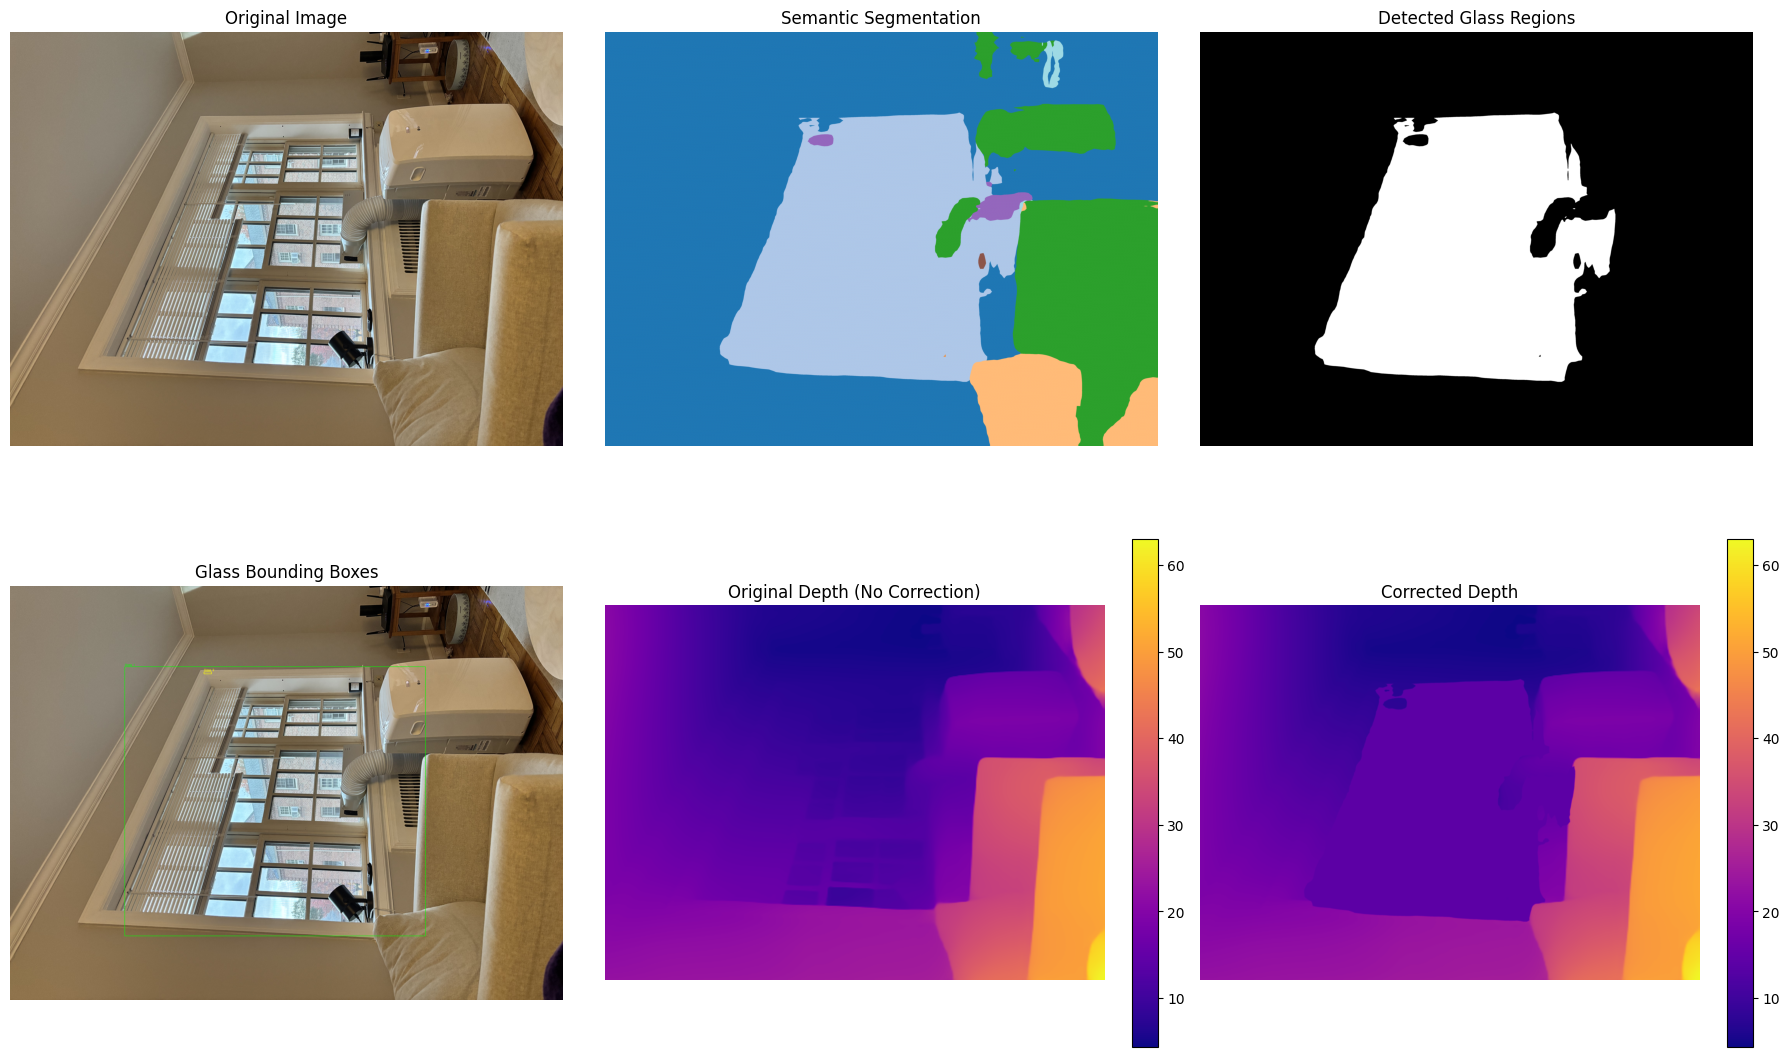


Processing image: .\test_images\tour.png
Loading image...
Running segmentation...
Estimating depth...
Detecting glass through depth anomaly analysis...
Combining detection methods...
Correcting depth map for glass regions...
Finding and classifying glass regions...
Found 5 glass regions
  Region 1: Transparent/Reflective (confidence: 1.00)
  Region 2: Transparent/Reflective (confidence: 1.00)
  Region 3: Transparent/Reflective (confidence: 1.00)
Analyzing glass depth correction quality...

=== Depth Correction Analysis ===
Surrounding (frame/wall) depth: 10.659
Glass depth before correction: 4.180
Glass depth after correction: 10.424
Error reduction: 96.4%
Successful correction - glass depth now matches surroundings


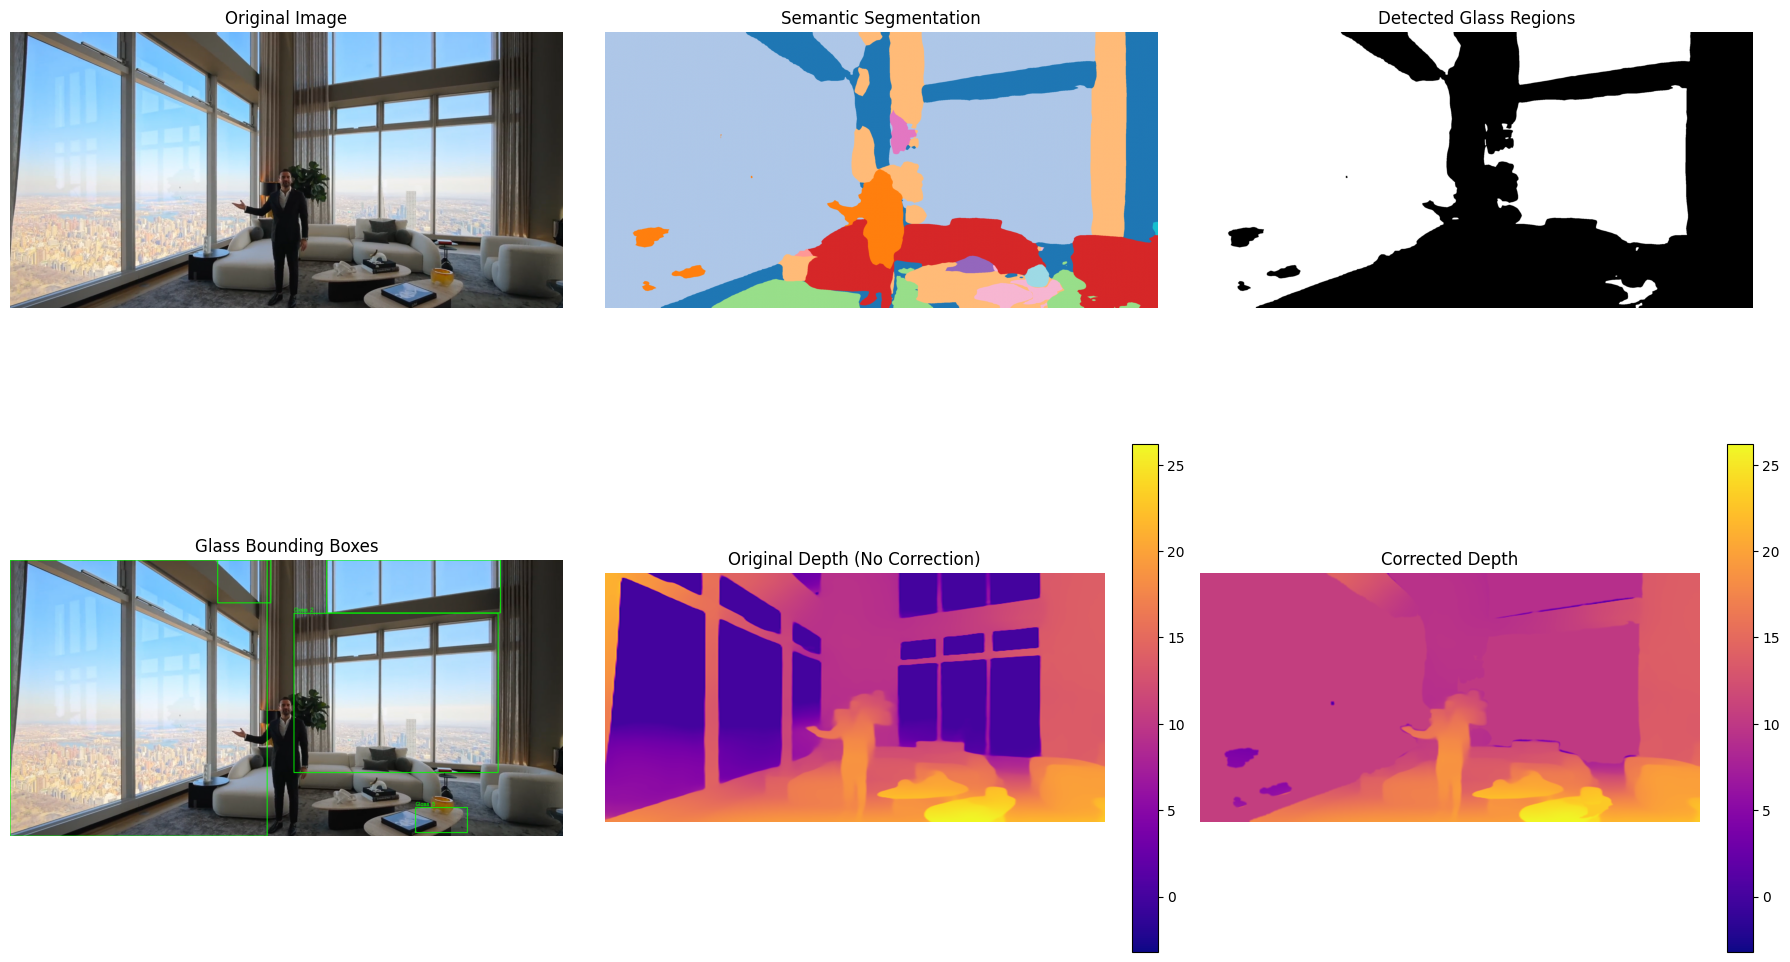


Processing image: .\test_images\20210927_164622-angle1-origin_0.png
Loading image...
Running segmentation...
Estimating depth...
Detecting glass through depth anomaly analysis...
Combining detection methods...
Correcting depth map for glass regions...
Finding and classifying glass regions...
Found 2 glass regions
  Region 1: Transparent/Reflective (confidence: 1.00)
  Region 2: Transparent/Reflective (confidence: 0.70)
Analyzing glass depth correction quality...

=== Depth Correction Analysis ===
Surrounding (frame/wall) depth: 8.914
Glass depth before correction: 8.134
Glass depth after correction: 8.477
Error reduction: 43.9%
Partial correction - some improvement achieved


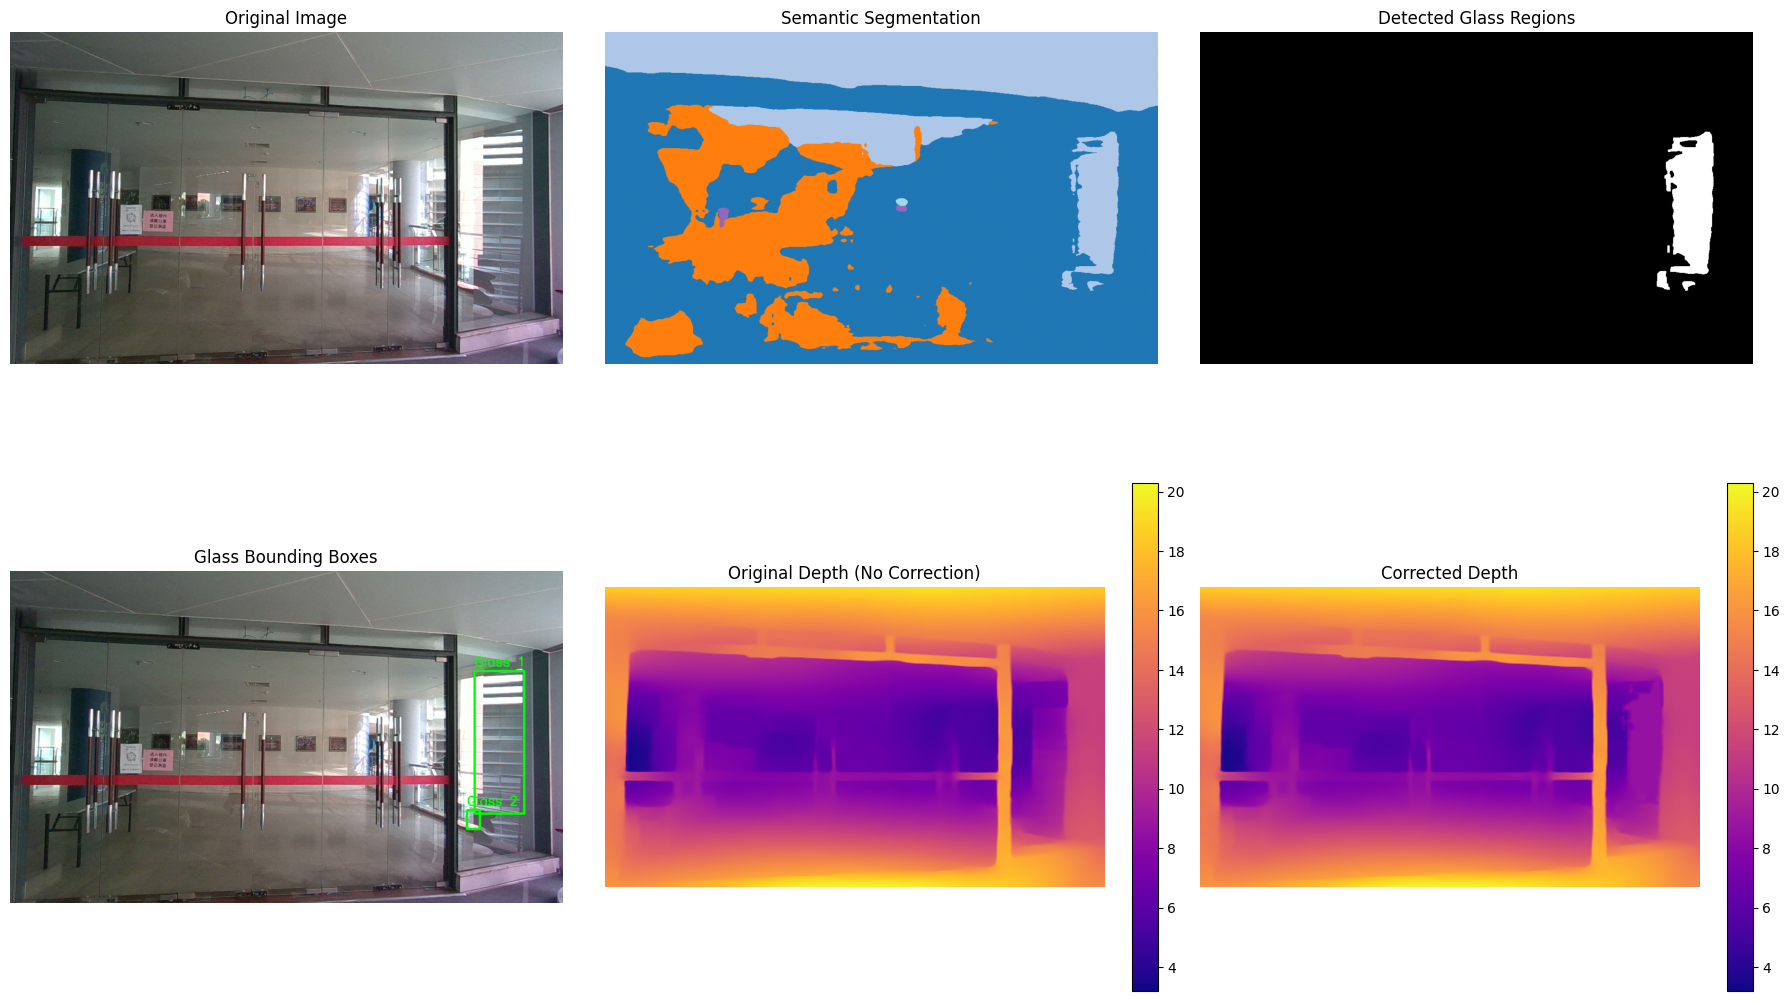


 Depth Correction Evaluation
Variance reduction in glass regions: 68.41%
Smoothness improvement: -0.004
Original depth range: 6.070
Corrected depth range: 5.463


In [23]:
# Initialize the glass-aware pipeline
pipeline = GlassAwareDepthPipeline()

# Example URLs with buildings/windows
sample_urls = [
    ".\\test_images\\Image.jpg",
    ".\\test_images\\tour.png",
    ".\\test_images\\20210927_164622-angle1-origin_0.png"
]

# Process with depth anomaly detection
for url in sample_urls:
    results = pipeline.process_image(url)

def evaluate_depth_correction(original_depth, corrected_depth, glass_mask):
    """
    Evaluate the quality of depth correction for glass regions
    """
    # Calculate metrics
    glass_pixels = glass_mask > 0
    
    if np.any(glass_pixels):
        # Variance reduction in glass regions
        original_variance = np.var(original_depth[glass_pixels])
        corrected_variance = np.var(corrected_depth[glass_pixels])
        variance_reduction = (original_variance - corrected_variance) / original_variance
        
        # Smoothness improvement
        original_gradient = np.gradient(original_depth)[0][glass_pixels]
        corrected_gradient = np.gradient(corrected_depth)[0][glass_pixels]
        smoothness_improvement = np.mean(np.abs(original_gradient)) - np.mean(np.abs(corrected_gradient))
        
        print("\n Depth Correction Evaluation")
        print(f"Variance reduction in glass regions: {variance_reduction:.2%}")
        print(f"Smoothness improvement: {smoothness_improvement:.3f}")
        print(f"Original depth range: {np.ptp(original_depth[glass_pixels]):.3f}")
        print(f"Corrected depth range: {np.ptp(corrected_depth[glass_pixels]):.3f}")
        
        return {
            'variance_reduction': variance_reduction,
            'smoothness_improvement': smoothness_improvement,
            'successful': variance_reduction > 0 and smoothness_improvement > 0
        }
    
    return None

# Evaluate the correction
if results['glass_mask'].any():
    evaluation = evaluate_depth_correction(
        results['depth_map'], 
        results['corrected_depth_map'],
        results['glass_mask']
    )